#California housing dataset#
Regression on california houseing dataset

#Loading the dataset#

In [1]:
from sklearn.datasets import fetch_california_housing

#Imports

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [31]:
import seaborn as sb

In order to analyze the dataset we load it as a dataframe

In [3]:
california_housing = fetch_california_housing(as_frame = True)

In [4]:
california_housing.frame.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Using ShuffleSplit as cv with 10 splits and 20% examples set aside as examples

In [5]:
cv = ShuffleSplit(n_splits = 10, test_size = .2)

**Data Spliting**

We load the data and split it into 3 parts train, validation and test. Train + validation will be used for cross validation and test will be used for evaluvating trained models

In [55]:
features, lables = fetch_california_housing(as_frame = True, return_X_y = True)
#train-test split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, lables)
# train --> train + validation split
train_features, val_features, train_labels, val_labels = train_test_split(com_train_features,com_train_labels)

<Axes: >

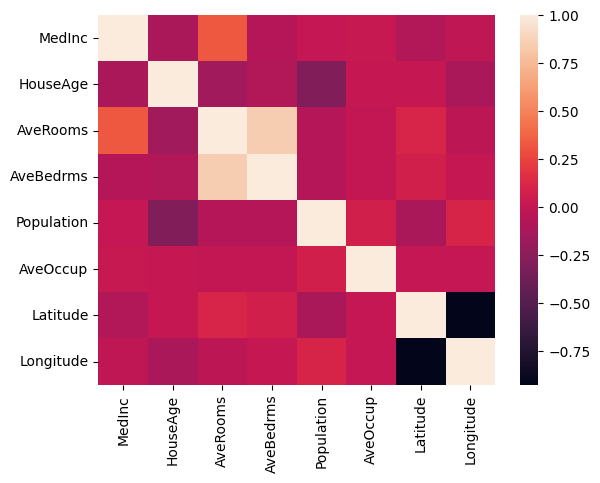

In [32]:
sb.heatmap(features.corr())

As we can see there are no significant correlations between the features

#Linear Regression with normal equation#

Pipline Setup


*   Feature scaling
*   Linear regression on the transformed feature matrix

We will use cross_validate for ShuffleSplit Cross validation and neg_mean_absolute_error as a scoring metric



In [7]:
lin_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                            ("lin_reg", LinearRegression())])
lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring = "neg_mean_absolute_error",
                                    return_train_score = True,
                                    return_estimator = True)
lin_reg_train_error = -1*lin_reg_cv_results['train_score']
lin_reg_test_error = -1*lin_reg_cv_results['test_score']
print("mean absolute error of linear regression on train set", lin_reg_train_error.mean(),"+/-",lin_reg_train_error.std())
print("mean absolute error of linear regression on test set", lin_reg_test_error.mean(),"+/-",lin_reg_test_error.std())

mean absolute error of linear regression on train set 0.5266005999880647 +/- 0.002205078676935576
mean absolute error of linear regression on test set 0.527301066809015 +/- 0.007305350784743464


Since errors are high this points to under fitting therfore we must add more features through polynomial regression

#Linear Regression with SGD#
Pipeline Stages


*   Feature scaling
*   SGD (Stochastic gradient descent) on the transformed dataset



In [20]:
sgd_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("sgd_reg", SGDRegressor(
                                max_iter=int(np.ceil(
                                    1e6/com_train_features.shape[0])),
                                early_stopping=True,
                                eta0=1e-4,
                                learning_rate='constant',
                                tol=1e-5,
                                validation_fraction=0.1,
                                n_iter_no_change=5,
                                average=10))])

sgd_reg_cv_results = cross_validate(sgd_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring = 'neg_mean_absolute_error',
                                    return_train_score = True,
                                    return_estimator = True)
sgd_train_error = -1*sgd_reg_cv_results['train_score']
sgd_test_error = -1*sgd_reg_cv_results['test_score']

print("mean absolute error of SGD regression on train set" ,sgd_train_error.mean(),"+/-",sgd_train_error.std())
print("mean absolute error of SGD regression on test set" ,sgd_test_error.mean(),"+/-",sgd_test_error.std())

mean absolute error of SGD regression on train set 0.5248907276879372 +/- 0.0018905482073210851
mean absolute error of SGD regression on test set 0.5246697477591804 +/- 0.005468920440855705


#Polynomial regression#

Training the model on degree 2 using 'PolynomialFeatures' transforms the features to the user specified degrees

In [26]:
poly_reg_pipeline = Pipeline([("poly",PolynomialFeatures(degree=2)),
                              ('feature_scaling', StandardScaler()),
                              ('lin_reg', LinearRegression())])
poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring = 'neg_mean_absolute_error',
                                    return_train_score = True,
                                    return_estimator = True)

poly_reg_train_error = -1*poly_reg_cv_results['train_score']
poly_reg_test_error = -1*poly_reg_cv_results['test_score']
print("mean absolute error of poly regression on train set" ,poly_reg_train_error.mean(),"+/-",poly_reg_test_error.std())
print("mean absolute error of poly regression on test set" ,poly_reg_train_error.mean(),"+/-",poly_reg_test_error.std())

mean absolute error of poly regression on train set 0.4572877107401103 +/- 0.010529058063395842
mean absolute error of poly regression on test set 0.4572877107401103 +/- 0.010529058063395842


We can see that error for degree 2 regression is lower than linear.

Instead of Using all polynomial feature, we use only interaction feature terms in polynomial model

In [28]:
poly_reg_pipeline = Pipeline([('poly',PolynomialFeatures(degree =2, interaction_only=True)),
                              ('feature_scaling', StandardScaler()),
                              ('lin_reg', LinearRegression())])
poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                     com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring = 'neg_mean_absolute_error',
                                    return_train_score = True,
                                    return_estimator = True)
poly_reg_train_error = -1*poly_reg_cv_results['train_score']
poly_reg_test_error = -1*poly_reg_cv_results['test_score']
print("mean absolute error of poly regression on train set" ,poly_reg_train_error.mean(),"+/-",poly_reg_test_error.std())
print("mean absolute error of poly regression on test set" ,poly_reg_train_error.mean(),"+/-",poly_reg_test_error.std())

mean absolute error of poly regression on train set 0.4729903778201141 +/- 0.0364161712076741
mean absolute error of poly regression on test set 0.4729903778201141 +/- 0.0364161712076741


Lets find out which degree of polynomial is best suited for the regression problem at hand

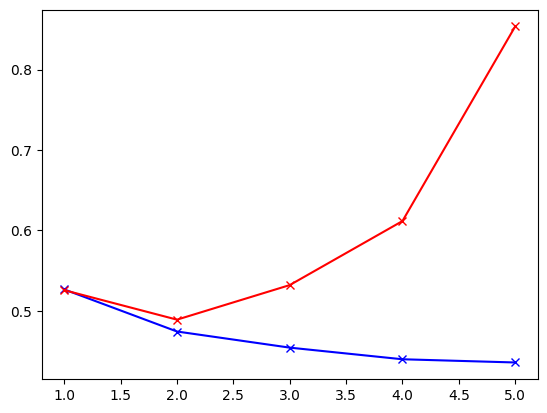

In [30]:
deg = [1,2,3,4,5]
train_scores, test_scores = validation_curve(poly_reg_pipeline,
                                             com_train_features,
                                            com_train_labels,
                                             param_name="poly__degree",
                                             param_range = deg,
                                             cv=cv,
                                             scoring="neg_mean_absolute_error",
                                             n_jobs =-1 )
train_errors, test_errors = -1*train_scores, -1*test_scores
plt.plot(deg,train_errors.mean(axis=1),'b-x', label = 'Training error')
plt.plot(deg,test_errors.mean(axis=1),'r-x', label = 'Test error')

Here we can see that polynomial beyond degree 2 leads to overfitting and therefore degree 2 is ideal for non regularized regression

#Ridge regression#


In [33]:
ridge_reg_pipeline = Pipeline([('poly',PolynomialFeatures(degree =2, interaction_only=True)),
                              ('feature_scaling', StandardScaler()),
                              ('ridge', Ridge(alpha=.5))])
ridge_reg_cv = cross_validate(ridge_reg_pipeline,
                              com_train_features,
                              com_train_labels,
                              cv=cv,
                              scoring = 'neg_mean_absolute_error',
                              return_train_score = True,
                              return_estimator = True)
ridge_reg_train_error = -1*ridge_reg_cv['train_score']
ridge_reg_test_error = -1*ridge_reg_cv['test_score']
print("mean absolute error of ridge regression on train set" ,ridge_reg_train_error.mean(),"+/-",ridge_reg_test_error.std())
print("mean absolute error of ridge regression on test set" ,ridge_reg_train_error.mean(),"+/-",ridge_reg_test_error.std())

mean absolute error of ridge regression on train set 0.4837596855580669 +/- 0.02007747540345789
mean absolute error of ridge regression on test set 0.4837596855580669 +/- 0.02007747540345789


#Hyper Parameter Tuning for ridge regularization

In [40]:
alpha_list = np.logspace(-4,0, num = 20)
ridge_reg_pipeline = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('feature_scaling', StandardScaler()),
                               ('ridge_cv', RidgeCV(alphas = alpha_list,
                                                    cv = cv,
                                                    scoring = 'neg_mean_absolute_error'))])
ridge_reg_cv_results = ridge_reg_pipeline.fit(com_train_features, com_train_labels)
print("score with best alpha is ",ridge_reg_cv_results[-1].best_score_)


score with best alpha is  -0.47570717533616574


In [41]:
print("best alpha", ridge_reg_cv_results[-1].alpha_)

best alpha 0.007847599703514606


#Performence on test set#

#Baseline#

In [57]:
baseline_model = DummyRegressor(strategy = 'median')
baseline_model.fit(train_features, train_labels)
mean_absolute_percentage_error(test_labels,
                               baseline_model.predict(test_features))

0.5110167863468267

#Linear regression#

In [58]:
mean_absolute_percentage_error(test_labels, lin_reg_cv_results['estimator'][0].predict(test_features))

0.30552829015110394

#Polynomial Regression degree 2 SGD#

In [60]:
mean_absolute_percentage_error(test_labels, poly_reg_cv_results['estimator'][0].predict(test_features))

0.2732280524351415

#Ridge Regression #

In [61]:
mean_absolute_percentage_error(test_labels, ridge_reg_cv_results.predict(test_features))

0.26112748405831493

#Summary#

Since Ridge Regression gives lowest mean absolute percentage error we will use that model.

In [74]:
import pickle
pickle.dump(ridge_reg_cv_results,open('ridge.pkl','wb'))